In [1]:
import json
import matplotlib.pyplot as plt
import os
import sys
import typing
from collections import defaultdict
import numpy as np
import pandas as pd
from pathlib import Path

from Bio import SeqIO
 

In [2]:
sys.path.append(str(Path(os.path.dirname(os.getcwd())).parent))

In [3]:
from input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus
from modules.main import run_modules
from modules import shared_functions_and_vars

In [4]:
def run_single_method_for_orf_sequence(optimization_method: str,
                                       is_ecoli_optimized: bool,
                                       orf_sequence: typing.Optional[str] = None,
                                       orf_sequence_file: typing.Optional[str] = None,
                                       output_path: typing.Optional[str] = None,
                                       optimization_cub_index: str = "CAI",
                                       tuning_param: float = 0.5):
    default_user_inp_raw = generate_testing_data_for_ecoli_and_bacillus(
        optimization_method=optimization_method,
        optimization_cub_index=optimization_cub_index,
        clusters_count=1,
        tuning_param=tuning_param,
        is_ecoli_optimized=is_ecoli_optimized,
        sequence=orf_sequence,
        sequence_file_path=orf_sequence_file,
        output_path=os.path.join("results", output_path),
    )
    return run_modules(default_user_inp_raw)

In [5]:
def run_all_methods(orf_sequence = None, orf_sequence_file = None, output_path = None, tuning_param: int = 0.5):
    for optimization_method in [
        "single_codon_ratio",
        "single_codon_diff",
        "single_codon_weakest_link",
        # "zscore_single_aa_ratio",
        "zscore_bulk_aa_ratio",
        # "zscore_single_aa_diff",
        "zscore_bulk_aa_diff",
        # "zscore_single_aa_weakest_link",
        "zscore_bulk_aa_weakest_link",
    ]:
        for optimization_cub_index in ["CAI", "tAI"]:
            for direction in [True, False]:
                run_single_method_for_orf_sequence(optimization_method=optimization_method,
                                                   optimization_cub_index=optimization_cub_index,
                                                   is_ecoli_optimized=direction,
                                                   orf_sequence=orf_sequence,
                                                   orf_sequence_file=orf_sequence_file,
                                                   output_path=output_path)

In [6]:
base_path = os.path.join(Path(os.getcwd()).parent.resolve(), "example_data")

## Generating mcherry variants

In [7]:
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")
run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry")

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3215
Calculate CAI weights from a reference set of 964 highly expressed genes from estimated expression dictionary.
name=Escherichia coli, cai_std=0.08137084728004947, cai_avg=0.6553953430191558

Information about Bacillus subtilis:
Organism is deoptimized
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 1863
Calculate CAI weights from a reference set of 559 highly expressed genes from estimated expression dictionary.
name=Bacillus subtilis, cai_std=0.039239181903582866, cai_avg=0.7451526432571732
Escherichia coli has weight of 1.0
Bacillus su

In [8]:
def generate_sequences_fasta_file(root_dir) -> None:
    filename = "run_summary.json"

    sequences = []
    sequences_names = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == filename:
                directory_name = Path(root).name
                file_path = os.path.join(root, file)
                with open(file_path, "r") as summary_file:
                    results_json = json.load(summary_file)

                seq = results_json["evaluation"]["final_sequence"]
                sequences.append(seq)
                sequences_names.append(directory_name[:-5])

    shared_functions_and_vars.write_fasta(os.path.join(root_dir, "mcherry_variants"), sequences, sequences_names)

In [9]:
mcherry_root_dir = r"C:\projects\Igem_TAU_2021_moran\analysis\orf_model_analysis\results\mcherry"
mcherry_variants_file = os.path.join(mcherry_root_dir, "mcherry_variants.fasta")

In [10]:
generate_sequences_fasta_file(mcherry_root_dir)

## Verification of variants translation to correct amino acid sequence

In [11]:
# Reference aa sequence is taken from: https://www.addgene.org/browse/sequence_vdb/6496/
reference_mcherry_protein_seq = "MVSKGEEDNMAIIKEFMRFKVHMEGSVNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFAWDILSPQFMYGSKAYVKHPADIPDYLKLSFPEGFKWERVMNFEDGGVVTVTQDSSLQDGEFIYKVKLRGTNFPSDGPVMQKKTMGWEASSERMYPEDGALKGEIKQRLKLKDGGHYDAEVKTTYKAKKPVQLPGAYNVNIKLDITSHNEDYTIVEQYERAEGRHSTGGMDELYK*"
formatted_reference_mcherry_protein_seq = reference_mcherry_protein_seq.replace("*", "_")

Validating original mcherry sequence:

In [12]:
with open(macherry_file_path, "r") as mcherry_fasta_file:
    mcherry_dict = SeqIO.to_dict(SeqIO.parse(mcherry_fasta_file, "fasta"))

original_mcherry_seq = list(mcherry_dict.values())[0].seq
translated_original_mcherry_seq = shared_functions_and_vars.translate(original_mcherry_seq)

assert translated_original_mcherry_seq == formatted_reference_mcherry_protein_seq

Validating generated mcherry variants:

In [13]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))

for variant_name, variant_seq in mcherry_variants_dict.items():
    translated_seq = shared_functions_and_vars.translate(variant_seq.seq)
    if translated_seq != formatted_reference_mcherry_protein_seq:
        raise ValueError(f"Variant {variant_name} is not coding to correct sequence. \nReference sequence: {formatted_reference_mcherry_protein_seq} \nVariant sequence: {translated_seq}")

## Calculating codon frequencies 

In [14]:
bacillus_endogenous_genes_fasta_file_path = r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis.fasta"
ecoli_endogenous_genes_fasta_file_path =  r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli.fasta"

In [15]:
def calculate_codon_frequencies(referece_cds: typing.Sequence[str]):
    codons_counter = defaultdict(int)
    
    for cds in referece_cds:
        if len(cds) % 3 != 0:
            continue
        for i in range(0, len(cds), 3):
            codon = cds[i:i+3]
            codons_counter[codon] += 1
    
    # Calculate relative frequncies

    for amino_acid, codons in shared_functions_and_vars.synonymous_codons.items():
        total_amino_acid_codons = 0
        for amino_acid_codon in codons:
            total_amino_acid_codons += codons_counter[amino_acid_codon]
        
        # In case a certain amino acid is missing from the reference cds collection, no need to normalize
        if total_amino_acid_codons == 0:
            continue
        
        for amino_acid_codon in codons:
            codons_counter[amino_acid_codon] /= total_amino_acid_codons
    
    df_dict = {"codon": list(codons_counter.keys()), "amino_acid": [shared_functions_and_vars.nt_to_aa[codon] for codon in codons_counter.keys()], "frequency": list(codons_counter.values())}
    return pd.DataFrame(df_dict)

In [16]:
def plot_frequency_map(frequency_df):
    sorted_df = frequency_df.sort_values("amino_acid")
    
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True

    sorted_df.plot("codon", "frequency", kind="bar", color = "b")

In [17]:
def calculate_distance_between_frequencies(first_codons_freq, second_codons_freq):
    return np.linalg.norm(first_codons_freq-second_codons_freq)

In [18]:
with open(bacillus_endogenous_genes_fasta_file_path, "r") as bacillus_endogenous_genes_fasta_file:
    bacillus_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(bacillus_endogenous_genes_fasta_file, "fasta"))

bacillus_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in bacillus_endogenous_genes_dict.values()])
bacillus_codon_frequencies = bacillus_codon_frequencies.sort_values("codon")

with open(ecoli_endogenous_genes_fasta_file_path, "r") as ecoli_endogenous_genes_fasta_file:
    ecoli_endogenous_genes_dict = SeqIO.to_dict(SeqIO.parse(ecoli_endogenous_genes_fasta_file, "fasta"))

ecoli_codon_frequencies = calculate_codon_frequencies([str(gene.seq) for gene in ecoli_endogenous_genes_dict.values()])
ecoli_codon_frequencies = ecoli_codon_frequencies.sort_values("codon")

In [19]:
original_mcherry_codon_frequencies = calculate_codon_frequencies((str(original_mcherry_seq),))
original_mcherry_codon_frequencies = original_mcherry_codon_frequencies.sort_values("codon")

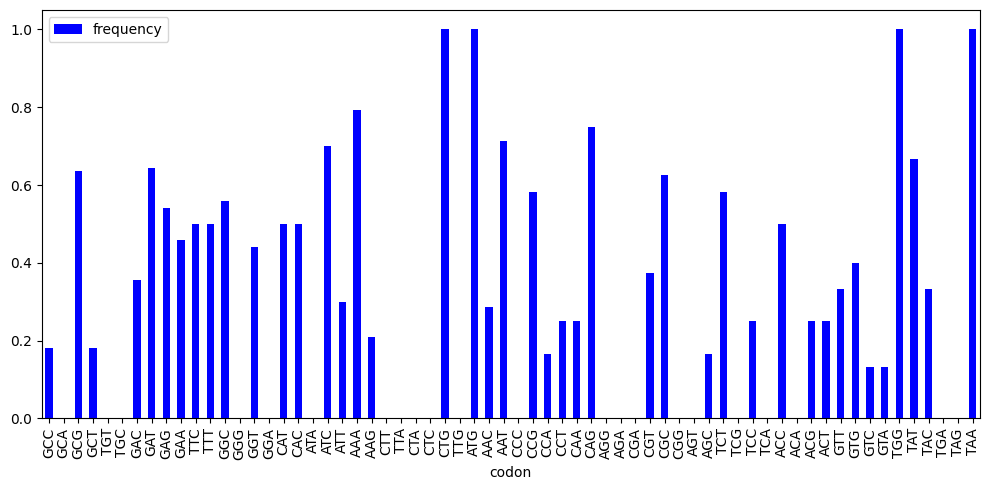

In [20]:
plot_frequency_map(original_mcherry_codon_frequencies)

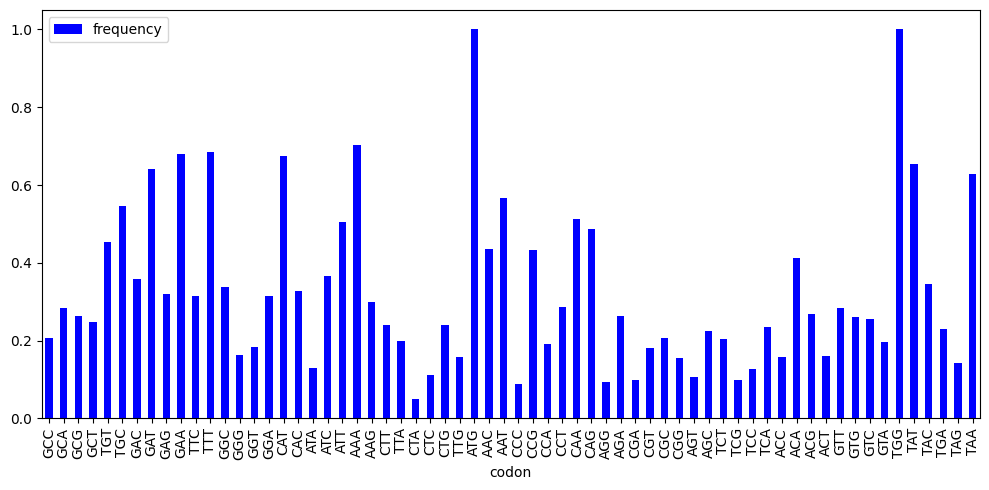

In [21]:
plot_frequency_map(bacillus_codon_frequencies)

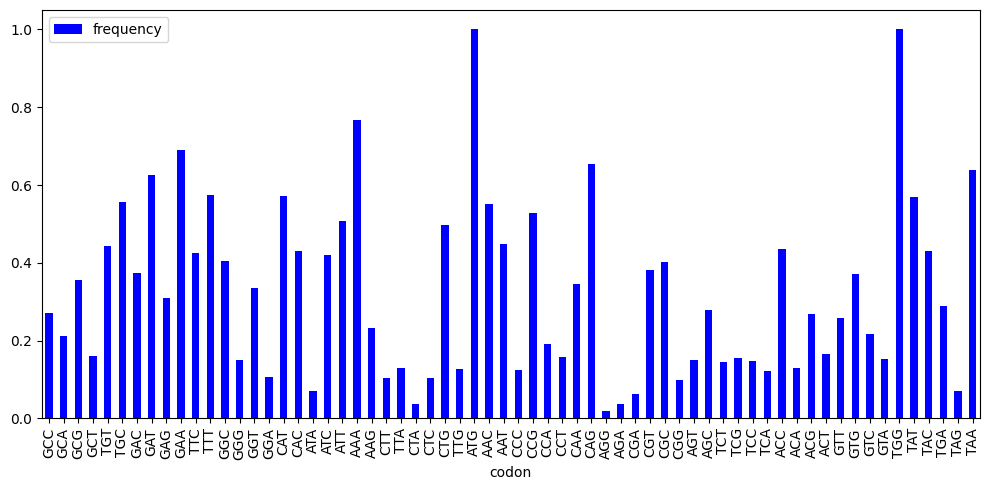

In [22]:
plot_frequency_map(ecoli_codon_frequencies)

In [23]:
original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_codon_frequencies["frequency"].reset_index(drop=True))

In [24]:
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_codon_frequencies["frequency"].reset_index(drop=True))

In [28]:
with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))


df_dict = {"variant": ["original_mcherry"], "ecoli_dist": [original_ecoli_dist], "bacillus_dist": [original_bacillus_dist]}    
for variant_name, variant_seq in mcherry_variants_dict.items():
    mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
    df_dict["variant"].append(variant_name)
    
    series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
    series2 =  ecoli_codon_frequencies["frequency"].reset_index(drop=True)
    series3 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)
    df_dict["ecoli_dist"].append(calculate_distance_between_frequencies(series1, series2))
    df_dict["bacillus_dist"].append(calculate_distance_between_frequencies(series1, series3))    

variants_dataframe = pd.DataFrame(df_dict)
ecoli_wanted_variants = variants_dataframe[variants_dataframe["variant"].str.contains("True")]
bacillus_wanted_variants = variants_dataframe[variants_dataframe["variant"].str.contains("False")]

<AxesSubplot:title={'center':'bacillus_wanted_variants'}, xlabel='variant'>

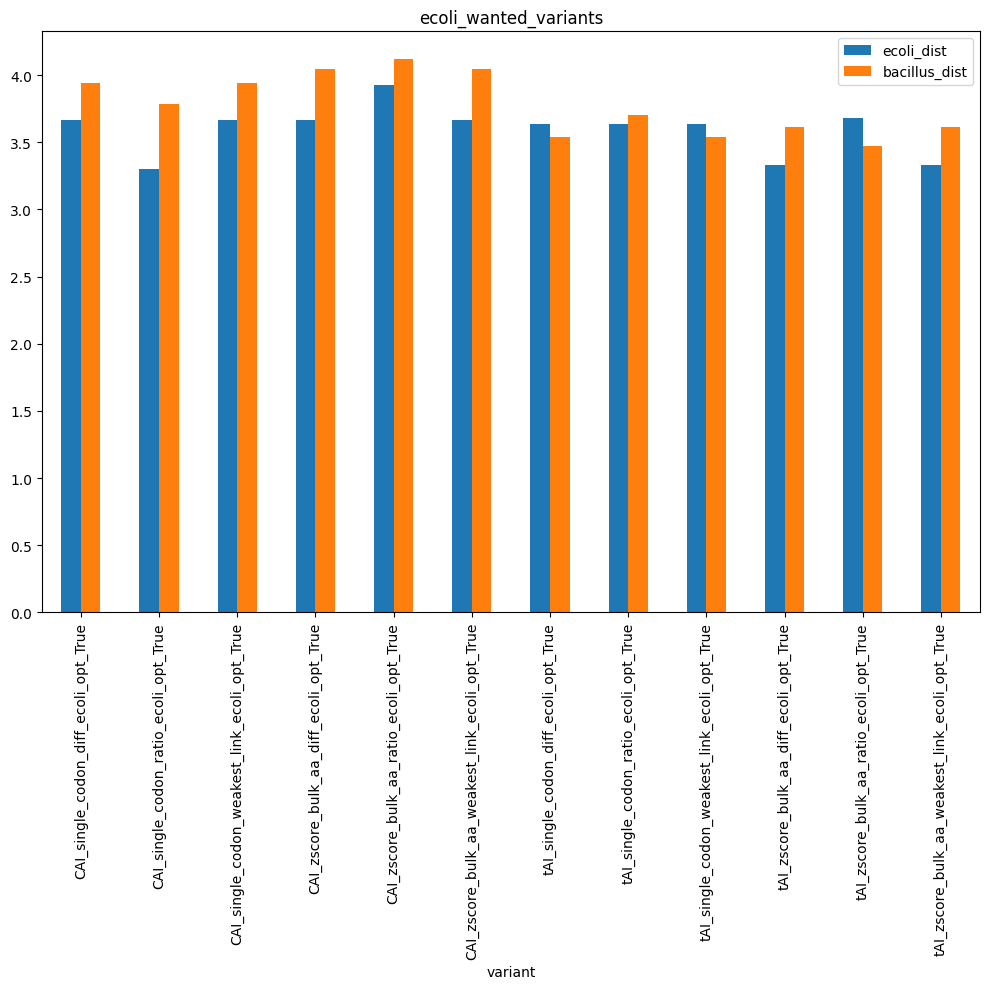

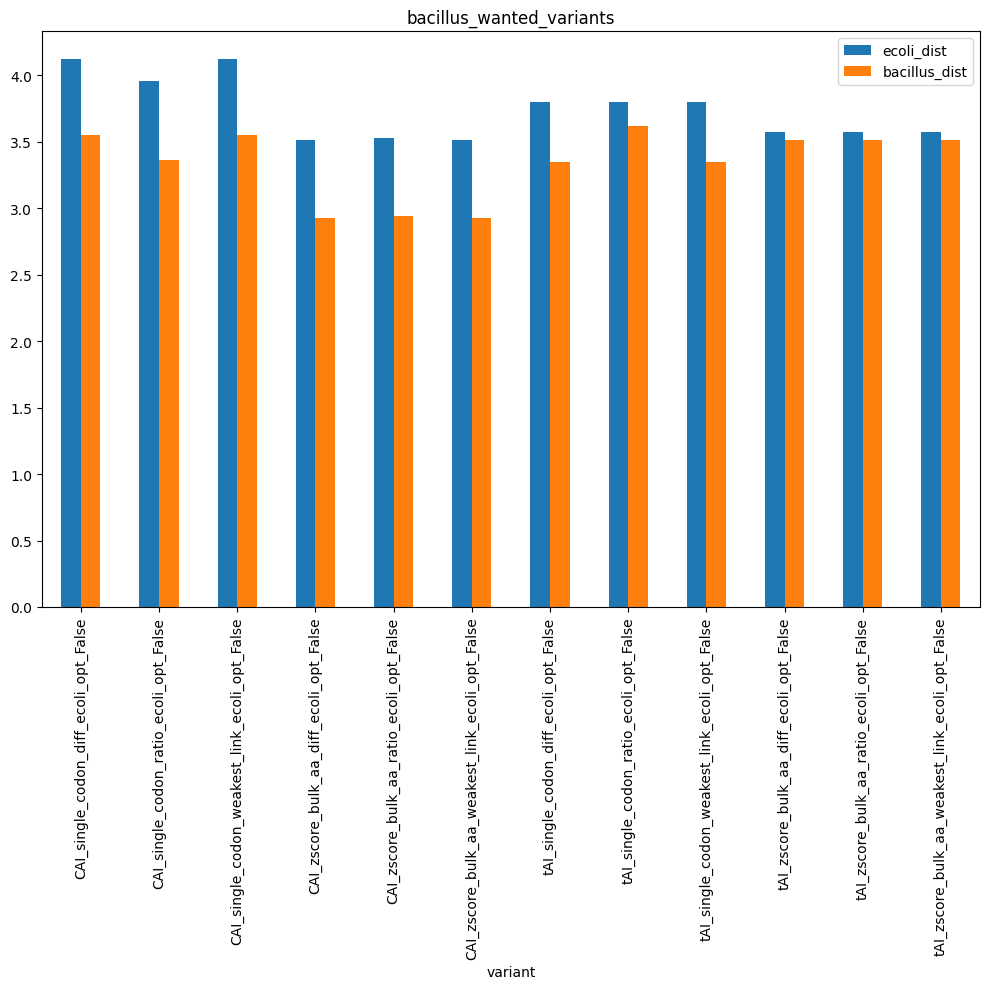

In [31]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
ecoli_wanted_variants.plot("variant", kind="bar", title="ecoli_wanted_variants")
bacillus_wanted_variants.plot("variant", kind="bar", title="bacillus_wanted_variants")

In [192]:
with open(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Bacillus-subtilis_False_parsed.json", "r") as parsed_bacillus_file:
    bacillus_summary = json.load(parsed_bacillus_file)

bacillus_cai_weights = bacillus_summary["cai_weights"]

with open(r"C:\projects\Igem_TAU_2021_moran\analysis\example_data\Escherichia-coli_False_parsed.json", "r") as parsed_ecoli_file:
    ecoli_summary = json.load(parsed_ecoli_file)

ecoli_cai_weights = ecoli_summary["cai_weights"]

bacillus_cai_weights = pd.DataFrame({"codon": list(bacillus_cai_weights.keys()), "weight": list(bacillus_cai_weights.values())}).sort_values("codon")
ecoli_cai_weights =  pd.DataFrame({"codon": list(ecoli_cai_weights.keys()), "weight": list(ecoli_cai_weights.values())}).sort_values("codon")
# series1 = bacillus_cai_weights["weight"].reset_index(drop=True)
# series2 =  bacillus_codon_frequencies["frequency"].reset_index(drop=True)
# calculate_distance_between_frequencies(series1, series2)

original_bacillus_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), bacillus_cai_weights["weight"].reset_index(drop=True))
original_ecoli_dist = calculate_distance_between_frequencies(original_mcherry_codon_frequencies["frequency"].reset_index(drop=True), ecoli_cai_weights["weight"].reset_index(drop=True))

with open(mcherry_variants_file, "r") as mcherry_variants_fasta_file:
    mcherry_variants_dict = SeqIO.to_dict(SeqIO.parse(mcherry_variants_fasta_file, "fasta"))


df_dict = {"variant": ["original_mcherry"], "ecoli_dist": [original_ecoli_dist], "bacillus_dist": [original_bacillus_dist]}    
for variant_name, variant_seq in mcherry_variants_dict.items():
    mcherry_variant_codon_frequencies = calculate_codon_frequencies((str(variant_seq.seq),)).sort_values("codon")
    df_dict["variant"].append(variant_name)
    
    series1 = mcherry_variant_codon_frequencies["frequency"].reset_index(drop=True)
    series2 =  ecoli_cai_weights["weight"].reset_index(drop=True)
    series3 =  bacillus_cai_weights["weight"].reset_index(drop=True)
    df_dict["ecoli_dist"].append(calculate_distance_between_frequencies(series1, series2))
    df_dict["bacillus_dist"].append(calculate_distance_between_frequencies(series1, series3))    

variants_dataframe = pd.DataFrame(df_dict)
variants_dataframe

,variant,ecoli_dist,bacillus_dist
0,original_mcherry,3.100379,3.932044
1,CAI_single_codon_diff_ecoli_opt_False,5.802056,5.137872
2,CAI_single_codon_diff_ecoli_opt_True,4.760187,5.731339
3,CAI_single_codon_ratio_ecoli_opt_False,4.389650,4.175730
4,CAI_single_codon_ratio_ecoli_opt_True,3.547807,4.769023
5,CAI_single_codon_weakest_link_ecoli_opt_False,5.802056,5.137872
6,CAI_single_codon_weakest_link_ecoli_opt_True,4.760187,5.731339
7,CAI_zscore_bulk_aa_diff_ecoli_opt_False,5.107870,4.374815
8,CAI_zscore_bulk_aa_diff_ecoli_opt_True,4.741597,5.776335
9,CAI_zscore_bulk_aa_ratio_ecoli_opt_False,5.120915,4.381391


<AxesSubplot:xlabel='variant'>

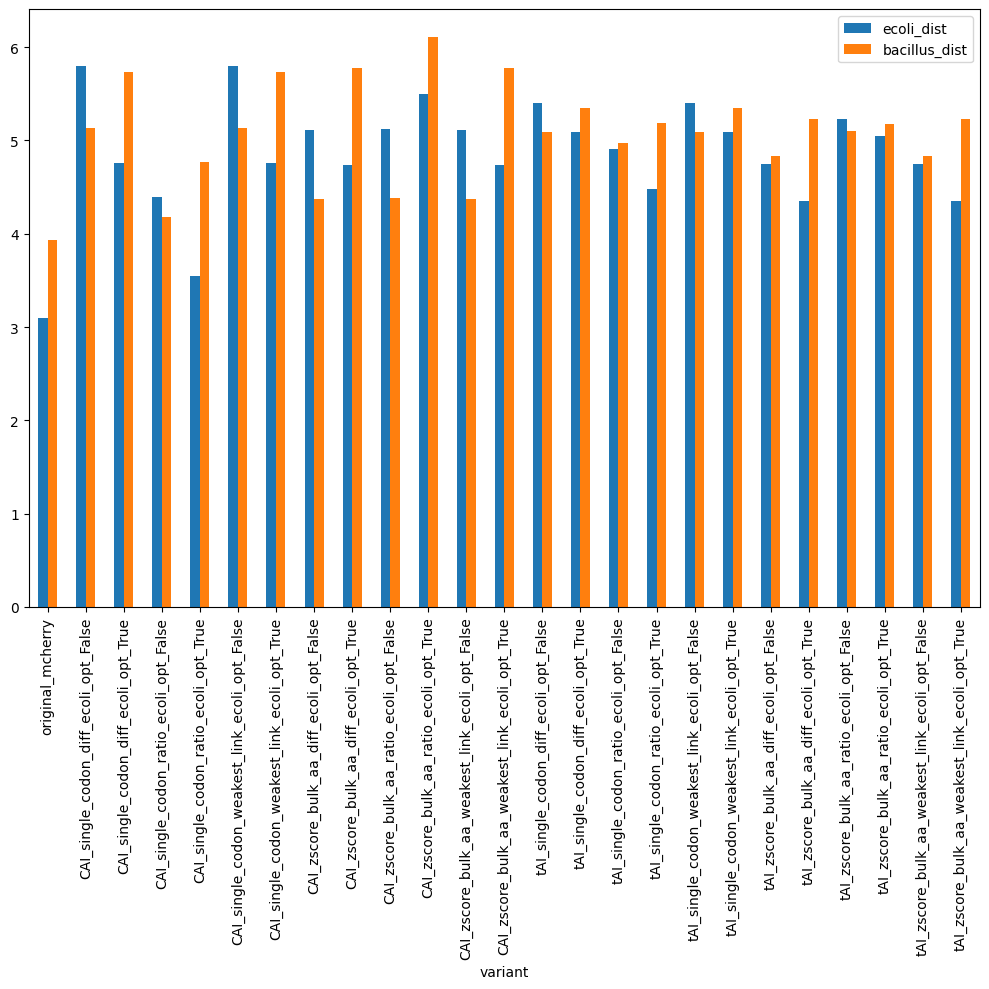

In [193]:
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
variants_dataframe.plot("variant", kind="bar")

Run for greater tuning paramter:

In [197]:
macherry_file_path = os.path.join(base_path, "mCherry_original.fasta")
run_all_methods(orf_sequence_file=macherry_file_path, output_path="mcherry_greter_alpha", tuning_param = 0.9)

##########################
# USER INPUT INFORMATION #
##########################

Information about Escherichia coli:
Organism is optimized
Number of genes: 4310
Found 90 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 3215
Calculate CAI weights from a reference set of 964 highly expressed genes from estimated expression dictionary.
name=Escherichia coli, cai_std=0.08137084728004947, cai_avg=0.6553953430191558

Information about Bacillus subtilis:
Organism is deoptimized
Number of genes: 4311
Found 98 ribosomal proteins in input genome.
CAI will be calculated from a reference set of estimated expression dictionary.
Expression levels were found for 1863
Calculate CAI weights from a reference set of 559 highly expressed genes from estimated expression dictionary.
name=Bacillus subtilis, cai_std=0.039239181903582866, cai_avg=0.7451526432571732
Escherichia coli has weight of 1.0
Bacillus su